# Adaline with mini-batch Stochastic Gradient Descent
The following code implements a simple object oriented Adaline classifier API trained using mini-batch Stochastic Gradient Descent. Mini-batch SGD is useful to approximate full batch gradient descent and accelerate convergence toword the global minimum of the loss function. It can help avoid local minima due to its noisy approximation of the full batch gradient and it can also be used to perform online learning.

In [1]:
import numpy as np

class AdalineBatchSGD:
    """A simple class implementation of the ADAptive LIner Neuron classifier using 
    mini-batch SGD for training.
    
    Parameters
    -----------
    eta: float
        Learning rate (between 0.0 and 1.0)
    n_iter: int
        Number of epochs (number of iterations over the training 
        dataset)
    batch_size: int
        Number of samples per batch
    shuffle: bool
        Set to True to shuffle randomly the samples for each epoch
    random_state: int
        Seed for the random initialization of the weights and bias.
    tol: float
        Loss value threshold below which the training stops, even if less than
        n_iter epochs were performed.
    """
    def __init__(self, eta=0.01, n_iter=50, batch_size=20, shuffle=True, random_state=1, tol=0.01 ):
        self.eta = eta
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.tol = tol

    def fit(self, X, y):
        """Trains the Adaline classifier to fit the training data using mini-batch SGD

        Parameters
        -----------
        X: [array-like], shape = [n_samples, n_features]
            Training vectors. n_features is the number of predictors
            per sample, while n_sample is the number of samples in 
            the training dataset
        y: array-like, shape = [n_samples]
            Vector with the corresponding class for each of the
            training samples in the training dataset

        Returns
        --------
        self:  object
        """
        self._initwb(X.shape[1])
        self.losses_ = []

        n_samples = X.shape[0]

        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            batch_losses = []
            for start_index in range(0, n_samples, self.batch_size):
                stop_index = start_index + self.batch_size
                X_b, y_b = X[start_index : stop_index], y[start_index : stop_index] 
                outputs = self._activation(self._netinput(X_b))
                errors = y_b - outputs
                self._w += self.eta * 2.0 * X_b.T.dot(errors) / X_b.shape[0]
                self._b += self.eta * 2.0 * errors.mean()
                batch_losses.append(np.mean(errors ** 2))

            avg_loss = np.mean(batch_losses)
            self.losses_.append(avg_loss)
            if avg_loss < self.tol:
                print(f'End of training, converged after {i + 1} iterations.')
                break
        else:
            print(f'End of training, max n of iterations ({self.n_iter}) reached.')    
        return self  
            
    def predict(self, X):
        """Calculate the output of the Adaline classifier and return class prediction"""
        net_input = self._netinput(X)
        return np.where(net_input >= 0.5, 1, 0)

    def _initwb(self, n_features):
        """Initialize weights and bias of the Adaline classifier"""
        self._rgen = np.random.default_rng(self.random_state)
        self._w = self._rgen.normal(loc=0.0, scale=0.01, size=n_features)
        self._b = np.float_(0.)

    def _netinput(self, X):
        """Calculate the weighted sum input to the neuron"""
        return X @ self._w + self._b

    def _activation(self, X):
        """Adaline activation function"""
        return X

    def _shuffle(self, X, y):
        """Shuffle the training data to avoid bias"""
        p = self._rgen.permutation(len(y))
        return X[p], y[p]

# Iris Dataset
We will use the Iris Dataset to test this simple Adaline implementation with mini-batch SGD.

In [2]:
import pandas as pd

df = pd.read_csv('iris.data.csv', header=None, encoding='utf-8')

# Select only Setosa and Versicolor targets
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# Extract sepal and petal length
X = df.iloc[0:100, [0, 2]].values

End of training, max n of iterations (14) reached.


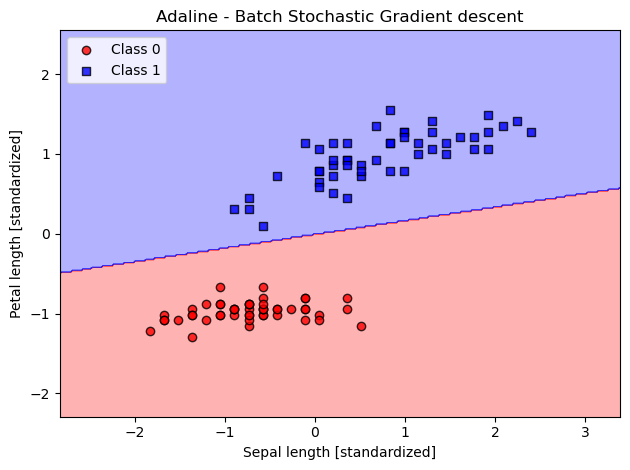

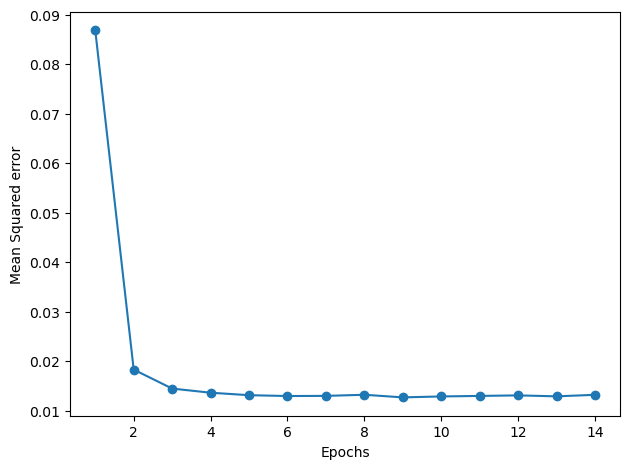

In [3]:
import matplotlib.pyplot as plt

# Make a copy of the dataset with standardized features
X_std = X.copy()
X_std[:,0] = (X_std[:,0] - X_std[:,0].mean()) / X_std[:,0].std()
X_std[:,1] = (X_std[:,1] - X_std[:,1].mean()) / X_std[:,1].std()

# Train the Adaline object
ada_gd = AdalineBatchSGD(eta=0.1, n_iter=14, batch_size=5)
ada_gd.fit(X_std, y)

# Function used to plot the decision boundary
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1 
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1 
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class example
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')


# Make plots
plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Batch Stochastic Gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_gd.losses_) + 1),
         ada_gd.losses_, 
         marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared error')
plt.tight_layout()
plt.show()